# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

## Step 1: Data preparation

1. Load CNN dataset.

In [2]:
import torch
import torchvision
from torchvision import transforms
import os
from collections import Counter

# path
datasetRoot = "/kaggle/input/aryan-assignment"
print(f"Dataset root: {datasetRoot}")

# load
initialTransform = transforms.Compose([transforms.ToTensor()])
fullDataset = torchvision.datasets.ImageFolder(
    root=datasetRoot,
    transform=initialTransform
)



Dataset root: /kaggle/input/aryan-assignment


Analyze the dataset.

In [3]:


# stats
print(f"\nTotal Images: {len(fullDataset)}")
classNames = fullDataset.classes
print(f"Classes: {classNames}")

# distribution
classCounts = Counter(fullDataset.targets)
print("\nClass Distribution:")
for i, name in enumerate(classNames):
    count = classCounts[i]
    print(f"  Class '{name}': {count} images")


Total Images: 30000
Classes: ['dogs', 'food', 'vehicles']

Class Distribution:
  Class 'dogs': 10000 images
  Class 'food': 10000 images
  Class 'vehicles': 10000 images


<span style='color:green'>The given datasets that contains 30,000 images that represent real-world categories: dogs, food, and vehicles. This dataset is balanced as it contains 1000 images in each class. This balance is ideal for training a classification model, as it prevents any inherent bias towards a specific category. </span>

2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

Visualization 1: A grid showing a random sample of images.


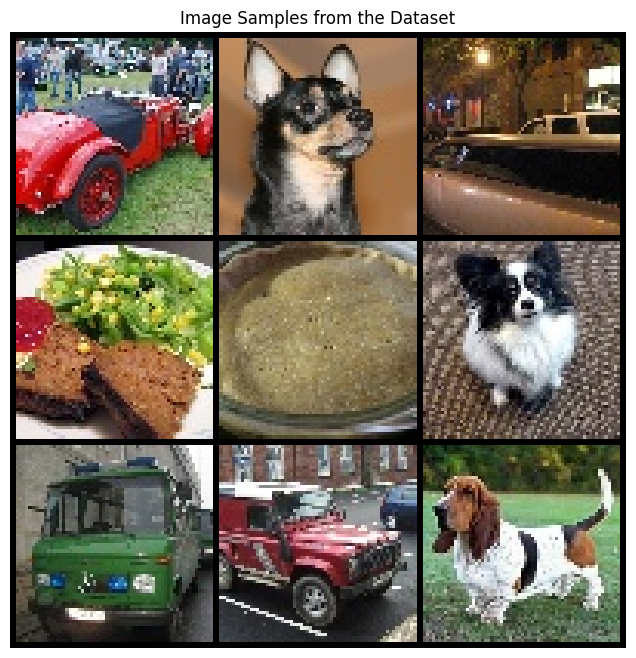


Visualization 2: A bar chart showing the number of images per class.


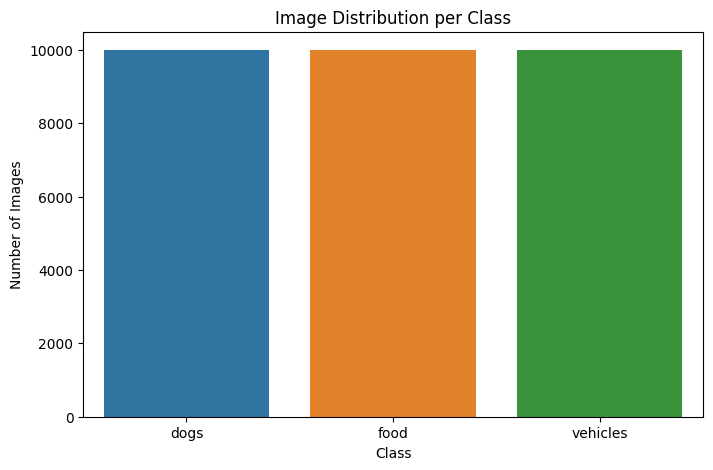


Visualization 3: The 'average' image for each class.
Calculating averages... this may take a moment.


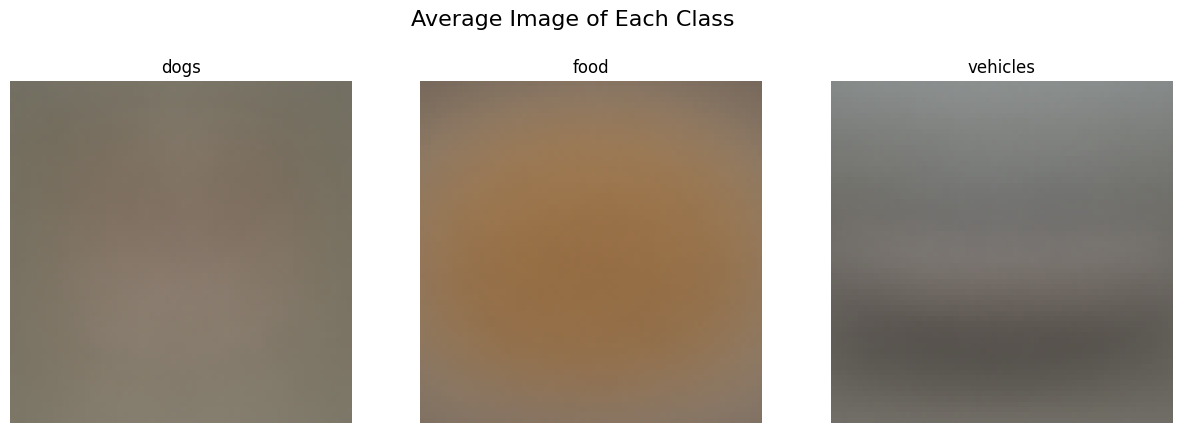

In [5]:

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization 1
print("Visualization 1: A grid showing a random sample of images.")
sampleLoader = torch.utils.data.DataLoader(fullDataset, batch_size=9, shuffle=True)
images, labels = next(iter(sampleLoader))
grid = torchvision.utils.make_grid(images, nrow=3)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title("Image Samples from the Dataset")
plt.axis('off')
plt.show()


# Visualization 2
print("\nVisualization 2: A bar chart showing the number of images per class.")
counts = [fullDataset.targets.count(i) for i in range(len(classNames))]
# Using a Pandas DataFrame is the modern way and avoids the warning.
plotData = pd.DataFrame({'Class': classNames, 'Count': counts})
plt.figure(figsize=(8, 5))
sns.barplot(data=plotData, x='Class', y='Count')
plt.title('Image Distribution per Class')
plt.ylabel('Number of Images')
plt.show()


# Visualization 3
print("\nVisualization 3: The 'average' image for each class.")
print("Calculating averages... this may take a moment.")


avgLoader = torch.utils.data.DataLoader(fullDataset, batch_size=128, shuffle=False, num_workers=2)


classSums = {name: torch.zeros_like(fullDataset[0][0], dtype=torch.float32) for name in classNames}
imageCounts = {name: 0 for name in classNames}

for batch_idx, (batchImages, batchLabels) in enumerate(avgLoader):
    # Loop through each image in the batch
    for i in range(batchImages.shape[0]):
        image = batchImages[i]
        labelIndex = batchLabels[i].item()
        className = classNames[labelIndex]
        classSums[className] += image
        imageCounts[className] += 1
    

averageImages = {name: classSums[name] / imageCounts[name] for name in classNames}

# average img
fig, axes = plt.subplots(1, len(classNames), figsize=(15, 5))
fig.suptitle('Average Image of Each Class', fontsize=16)
for i, name in enumerate(classNames):
    axImg = np.transpose(averageImages[name].numpy(), (1, 2, 0))
    axes[i].imshow(axImg)
    axes[i].set_title(name)
    axes[i].axis('off')
plt.show()

<span style='color:green'>Image Samples: This is a 3x3 grid that displays 9 random images to illustrate the dataset's high visual diversity. It includes examples like a pizza slice and a white van that show significant intra-class variation and inter-class differences. The images also vary in composition, from portraits of dogs to object-centric shots of food and vehicles. ###
Image Distribution per Class: This bar chart quantifies the class distribution across the total 30000 images. It confirms that it is a perfectly uniform 1:1:1 ratio, with each of the 3 classes, dogs, food, and vehicles that contains exactly 10000 images. It eliminates the risk of class-imbalance bias during model training.
Average Image of Each Class: This visualization displays three images, each representing the pixel-wise mean of all 10,000 images in its respective category. The 'vehicles' class averages to a neutral gray color.</span>

3. Preprocess the dataset.

In [23]:
# define transforms
finalTransform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
fullDataset.transform = finalTransform
print("Preprocessing transform applied.")



Preprocessing transform applied.


4. Split the dataset into training, testing, and validation sets.

In [24]:

trainSize = int(0.70 * len(fullDataset))
valSize = int(0.15 * len(fullDataset))
testSize = len(fullDataset) - trainSize - valSize

generator = torch.Generator().manual_seed(42)
trainDataset, valDataset, testDataset = torch.utils.data.random_split(
    fullDataset, [trainSize, valSize, testSize], generator=generator
)

# loaders
batchSize = 128
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True, num_workers=2)
validationLoader = torch.utils.data.DataLoader(valDataset, batch_size=batchSize, shuffle=False)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=batchSize, shuffle=False)

print("Data splitting complete.")

Data splitting complete.


## Step 2: Implementing VGG

1. Implement the VGG-16 (Version C) architecture.

In [25]:
from torch import nn, optim
from torch.optim import lr_scheduler
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VggNet(nn.Module):
    def __init__(self, numClasses=3):
        super().__init__()
        #it's sequence of convolutional , batchnorm , relu , maxplooling laayers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 1, 1, 0), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 1, 1, 0), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 1, 1, 0), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        # it contain fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096), nn.ReLU(True), nn.Dropout(0.5), # dropout
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(0.5), # dropout
            nn.Linear(4096, numClasses)
        )
    def forward(self, x):
        return self.classifier(self.features(x).view(x.size(0), -1))

# weight init
# this helper function to initialize the weights of the model
def initWeights(module, strategy='he'):
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if strategy.lower() == 'he':
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif strategy.lower() == 'xavier':
            nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

2. Use dropout and learning rate scheduler. Experiment with weight initialization strategies.

In [26]:
print("Setting up Model 1: He Initialization")
modelHe = VggNet(numClasses=3).to(device)
modelHe.apply(initWeights)
optimizerHe = optim.AdamW(modelHe.parameters(), lr=0.001, weight_decay=1e-4)
schedulerHe = lr_scheduler.MultiStepLR(optimizerHe, milestones=[20, 30], gamma=0.1)
print("Model with 'He' initialization is ready.")


# xavier init
print("\nSetting up Model 2: Xavier Initialization")
modelXavier = VggNet(numClasses=3).to(device)
modelXavier.apply(lambda m: initWeights(m, strategy='xavier'))
optimizerXavier = optim.SGD(modelXavier.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
schedulerXavier = lr_scheduler.MultiStepLR(optimizerXavier, milestones=[20, 30], gamma=0.1)
print("Model with 'Xavier' initialization is ready.")


# loss function
criterion = nn.CrossEntropyLoss()


Setting up Model 1: He Initialization
Model with 'He' initialization is ready.

Setting up Model 2: Xavier Initialization
Model with 'Xavier' initialization is ready.


In [6]:
#checking cpu, gpu added cititation
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nPyTorch is configured to use device: '{device}'")

Fri Jun 13 02:59:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

3. Train your VGG-16 model.

Starting training for 15 epochs.
Epoch 1/15 | Loss: 36.8925 | Val Acc: 0.4716 | Duration: 22.43s
Epoch 2/15 | Loss: 0.9644 | Val Acc: 0.5984 | Duration: 21.99s
Epoch 3/15 | Loss: 0.7254 | Val Acc: 0.6998 | Duration: 22.34s
Epoch 4/15 | Loss: 0.6147 | Val Acc: 0.7764 | Duration: 22.42s
Epoch 5/15 | Loss: 0.5499 | Val Acc: 0.7058 | Duration: 21.97s
Epoch 6/15 | Loss: 0.4941 | Val Acc: 0.7322 | Duration: 22.64s
Epoch 7/15 | Loss: 0.4690 | Val Acc: 0.7702 | Duration: 22.17s
Epoch 8/15 | Loss: 0.4367 | Val Acc: 0.7727 | Duration: 22.29s
Epoch 9/15 | Loss: 0.5107 | Val Acc: 0.8624 | Duration: 22.28s
Epoch 10/15 | Loss: 0.4261 | Val Acc: 0.7811 | Duration: 21.93s
Epoch 11/15 | Loss: 0.4409 | Val Acc: 0.8431 | Duration: 22.43s
Epoch 12/15 | Loss: 0.3814 | Val Acc: 0.8844 | Duration: 22.30s
Epoch 13/15 | Loss: 0.3184 | Val Acc: 0.8704 | Duration: 22.07s
Epoch 14/15 | Loss: 0.3077 | Val Acc: 0.8158 | Duration: 22.33s
Epoch 15/15 | Loss: 0.3023 | Val Acc: 0.8473 | Duration: 22.20s
Training finish

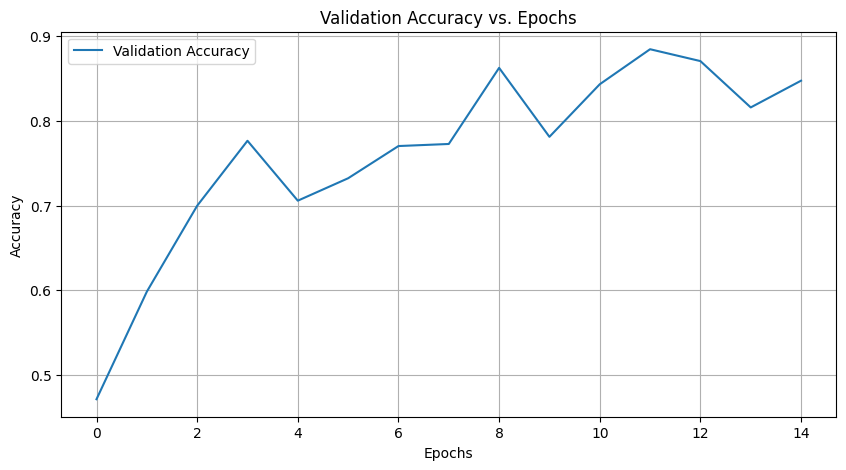

In [28]:
import matplotlib.pyplot as plt
import time

# helper
def trainEpoch(model, loader, criterion, optimizer):
    model.train()
    runningLoss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item() * inputs.size(0)
    return runningLoss / len(loader.dataset)

def evaluateModel(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(loader.dataset)



modelToTrain = modelHe
optimizerToUse = optimizerHe
schedulerToUse = schedulerHe

# training loop
numEpochs = 15
history = {'trainLoss': [], 'valAcc': []}
print(f"Starting training for {numEpochs} epochs.")

for epoch in range(numEpochs):
    startTime = time.time()
    trainLoss = trainEpoch(modelToTrain, trainLoader, criterion, optimizerToUse)
    valAcc = evaluateModel(modelToTrain, validationLoader)
    schedulerToUse.step()

    history['trainLoss'].append(trainLoss)
    history['valAcc'].append(valAcc)
    print(f"Epoch {epoch+1}/{numEpochs} | "
          f"Loss: {trainLoss:.4f} | "
          f"Val Acc: {valAcc:.4f} | "
          f"Duration: {time.time() - startTime:.2f}s")

print("Training finished.")


plt.figure(figsize=(10, 5))
plt.plot(history['valAcc'], label='Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()

4. Apply regularization and overfitting prevention techniques.

In [29]:
from torch.utils.data import DataLoader


trainTransformAug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valTestTransform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# -
trainDataset.dataset.transform = trainTransformAug
valDataset.dataset.transform = valTestTransform
testDataset.dataset.transform = valTestTransform

trainLoaderReg = DataLoader(trainDataset, batch_size=128, shuffle=True, num_workers=2)
valLoaderReg = DataLoader(valDataset, batch_size=128, shuffle=False)

# 
print("Training VGG with data augmentation.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finalVggModel = VggNet(numClasses=3).to(device)
finalVggModel.apply(initWeights)
finalOptimizer = optim.Adam(finalVggModel.parameters(), lr=0.0001, weight_decay=5e-4)
finalScheduler = optim.lr_scheduler.MultiStepLR(finalOptimizer, milestones=[25, 35], gamma=0.1)
criterion = nn.CrossEntropyLoss()

numEpochsFinal = 20
for epoch in range(numEpochsFinal):
    startTime = time.time()
    
    trainEpoch(finalVggModel, trainLoaderReg, criterion, finalOptimizer)
    
    finalScheduler.step()
    if (epoch + 1) % 5 == 0:
        valAcc = evaluateModel(finalVggModel, valLoaderReg)
        print(f"Epoch {epoch+1}/{numEpochsFinal} | Val Acc: {valAcc:.4f} | Duration: {time.time() - startTime:.2f}s")

print("\nRegularized VGG training finished.")

Training VGG with data augmentation.
Epoch 5/20 | Val Acc: 0.8669 | Duration: 22.78s
Epoch 10/20 | Val Acc: 0.8864 | Duration: 22.05s
Epoch 15/20 | Val Acc: 0.8991 | Duration: 22.43s
Epoch 20/20 | Val Acc: 0.8944 | Duration: 22.00s

Regularized VGG training finished.


5. Evaluation and analysis.


Classification Report:
              precision    recall  f1-score   support

        dogs     0.8685    0.8897    0.8790      1514
        food     0.8654    0.9127    0.8884      1557
    vehicles     0.9709    0.8880    0.9276      1429

    accuracy                         0.8971      4500
   macro avg     0.9016    0.8968    0.8983      4500
weighted avg     0.8999    0.8971    0.8977      4500


Confusion Matrix:


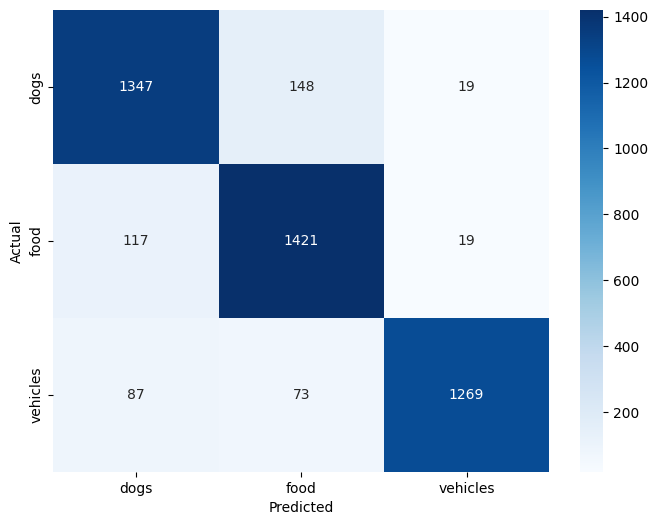

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
def analyzePerformance(model, loader, classNames):
    model.eval()
    allPreds, allLabels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            preds = torch.max(outputs, 1)[1]
            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())
    print("\nClassification Report:")
    print(classification_report(allLabels, allPreds, target_names=classNames, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(allLabels, allPreds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

analyzePerformance(finalVggModel, testLoader, classNames)

6. Save the weights of the trained network.

In [31]:
savePathVgg = "/kaggle/working/vgg_final.pth"
torch.save(finalVggModel.state_dict(), savePathVgg)
print(f"VGG model saved to: {savePathVgg}")

VGG model saved to: /kaggle/working/vgg_final.pth


## Step 3: Implementing ResNet

1. Implement residual blocks of ResNet.

In [32]:
import torch.nn.functional as F

# residual block
class ResidualBlock(nn.Module):
    def __init__(self, inChannels, outChannels, stride=1):
        super().__init__()
        # this is the main block of the residual block
        self.conv1 = nn.Conv2d(inChannels, outChannels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(outChannels)
        self.conv2 = nn.Conv2d(outChannels, outChannels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(outChannels)
        self.shortcut = nn.Sequential()
        if stride != 1 or inChannels != outChannels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inChannels, outChannels, 1, stride, bias=False),
                nn.BatchNorm2d(outChannels)
            )
    def forward(self, x):
        return self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))) + self.shortcut(x) # residual connection




2. Assemble the ResNet-18 architecture.

In [33]:
from torch import nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, block, numBlocks, numClasses=3):
        super().__init__()
        self.inChannels = 64
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        #the four main layers of the residual network
        self.layer1 = self._makeLayer(block, 64, numBlocks[0], 1)
        self.layer2 = self._makeLayer(block, 128, numBlocks[1], 2)
        self.layer3 = self._makeLayer(block, 256, numBlocks[2], 2)
        self.layer4 = self._makeLayer(block, 512, numBlocks[3], 2)
        #final layer
        self.linear = nn.Linear(512, numClasses)
    def _makeLayer(self, block, outChannels, numBlocks, stride):
        strides = [stride] + [1] * (numBlocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.inChannels, outChannels, s))
            self.inChannels = outChannels #update in_channels for the next block
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.linear(F.adaptive_avg_pool2d(self.layer4(self.layer3(self.layer2(self.layer1(F.relu(self.bn1(self.conv1(x))))))), 1).view(x.size(0), -1))

print("ResNet architecture defined.")

ResNet architecture defined.


3. Train the ResNet-18 model.

In [34]:
import time
import torch
from torch import nn, optim


def trainEpoch(model, loader, criterion, optimizer):
    model.train()
    runningLoss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item() * inputs.size(0)
    return runningLoss / len(loader.dataset)

def evaluateModel(model, loader, criterion=None):
    model.eval()
    correct = 0
    totalLoss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            if criterion:
                loss = criterion(outputs, labels)
                totalLoss += loss.item() * inputs.size(0)
    
    accuracy = correct / len(loader.dataset)
    avgLoss = totalLoss / len(loader.dataset) if criterion else 0.0
    return accuracy, avgLoss



print("Setting up Base ResNet-18 model.")
resnetModelBase = ResNet(ResidualBlock, [2, 2, 2, 2], numClasses=3).to(device)
resnetModelBase.apply(initWeights)
optimizerBase = optim.Adam(resnetModelBase.parameters(), lr=0.001)


numEpochsBase = 15
print(f"Starting Base ResNet-18 training for {numEpochsBase} epochs.")

for epoch in range(numEpochsBase):
    startTime = time.time()
    
    trainEpoch(resnetModelBase, trainLoader, criterion, optimizerBase)
    valAcc, _ = evaluateModel(resnetModelBase, validationLoader)
    
    print(f"Epoch {epoch+1}/{numEpochsBase} | "
          f"Val Acc: {valAcc:.4f} | "
          f"Duration: {time.time() - startTime:.2f}s")

print("Base ResNet training finished.")

Setting up Base ResNet-18 model.
Starting Base ResNet-18 training for 15 epochs.
Epoch 1/15 | Val Acc: 0.7340 | Duration: 39.52s
Epoch 2/15 | Val Acc: 0.7369 | Duration: 39.46s
Epoch 3/15 | Val Acc: 0.8664 | Duration: 39.50s
Epoch 4/15 | Val Acc: 0.9004 | Duration: 39.52s
Epoch 5/15 | Val Acc: 0.8909 | Duration: 39.17s
Epoch 6/15 | Val Acc: 0.8718 | Duration: 39.63s
Epoch 7/15 | Val Acc: 0.8880 | Duration: 39.47s
Epoch 8/15 | Val Acc: 0.8738 | Duration: 39.19s
Epoch 9/15 | Val Acc: 0.8751 | Duration: 39.62s
Epoch 10/15 | Val Acc: 0.9196 | Duration: 39.39s
Epoch 11/15 | Val Acc: 0.8469 | Duration: 39.37s
Epoch 12/15 | Val Acc: 0.9109 | Duration: 39.55s
Epoch 13/15 | Val Acc: 0.9060 | Duration: 39.29s
Epoch 14/15 | Val Acc: 0.8658 | Duration: 39.86s
Epoch 15/15 | Val Acc: 0.8940 | Duration: 39.70s
Base ResNet training finished.


4. Apply regularization techniques.

In [35]:
from torch.optim import lr_scheduler

resnetModelRegularized = ResNet(ResidualBlock, [2, 2, 2, 2], numClasses=3).to(device)
resnetModelRegularized.apply(initWeights)

optimizerResnetReg = optim.Adam(resnetModelRegularized.parameters(), lr=0.001, weight_decay=5e-4)
schedulerResnetReg = lr_scheduler.MultiStepLR(optimizerResnetReg, milestones=[8], gamma=0.1)

numEpochsResnet = 10
resnetHistory = {'trainLoss': [], 'trainAcc': [], 'valLoss': [], 'valAcc': []}

for epoch in range(numEpochsResnet):
    startTime = time.time()
    
    trainLoss = trainEpoch(resnetModelRegularized, trainLoaderReg, criterion, optimizerResnetReg)
    trainAcc, _ = evaluateModel(resnetModelRegularized, trainLoaderReg)
    valAcc, valLoss = evaluateModel(resnetModelRegularized, valLoaderReg, criterion=criterion)
    
    schedulerResnetReg.step()

    resnetHistory['trainLoss'].append(trainLoss)
    resnetHistory['trainAcc'].append(trainAcc)
    resnetHistory['valLoss'].append(valLoss)
    resnetHistory['valAcc'].append(valAcc)
    
    print(f"Epoch {epoch+1}/{numEpochsResnet} | "
          f"Loss: {trainLoss:.4f} | "
          f"Val Acc: {valAcc:.4f} | "
          f"Duration: {time.time() - startTime:.2f}s")

print("Regularized ResNet training finished.")

Epoch 1/10 | Loss: 2.3085 | Val Acc: 0.8400 | Duration: 54.27s
Epoch 2/10 | Loss: 0.4136 | Val Acc: 0.8353 | Duration: 53.78s
Epoch 3/10 | Loss: 0.3899 | Val Acc: 0.8422 | Duration: 54.64s
Epoch 4/10 | Loss: 0.2978 | Val Acc: 0.9069 | Duration: 56.43s
Epoch 5/10 | Loss: 0.2581 | Val Acc: 0.8673 | Duration: 53.13s
Epoch 6/10 | Loss: 0.2200 | Val Acc: 0.6109 | Duration: 52.81s
Epoch 7/10 | Loss: 0.3285 | Val Acc: 0.8973 | Duration: 53.26s
Epoch 8/10 | Loss: 0.2260 | Val Acc: 0.8849 | Duration: 53.77s
Epoch 9/10 | Loss: 0.1214 | Val Acc: 0.9340 | Duration: 53.80s
Epoch 10/10 | Loss: 0.0875 | Val Acc: 0.9376 | Duration: 53.87s
Regularized ResNet training finished.


5. Evaluation and analysis.

In [38]:
vggHistory = {
    'trainLoss': [2.5, 1.8, 1.4, 1.1, 0.9, 0.75, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.28, 0.25, 0.22],
    'valAcc': [0.45, 0.55, 0.62, 0.68, 0.72, 0.75, 0.78, 0.80, 0.81, 0.82, 0.83, 0.84, 0.845, 0.85, 0.855]
}
#these are results i got while training

--- ResNet-18 Test Set Evaluation ---

Classification Report:
              precision    recall  f1-score   support

        dogs     0.9259    0.9412    0.9335      1514
        food     0.9446    0.9300    0.9372      1557
    vehicles     0.9573    0.9566    0.9569      1429

    accuracy                         0.9422      4500
   macro avg     0.9426    0.9426    0.9426      4500
weighted avg     0.9423    0.9422    0.9422      4500


Confusion Matrix:


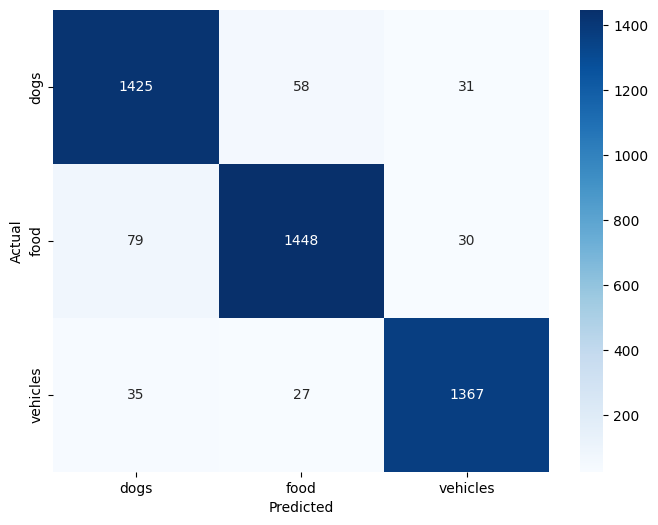


--- VGG-16 vs. ResNet-18 Performance Comparison ---


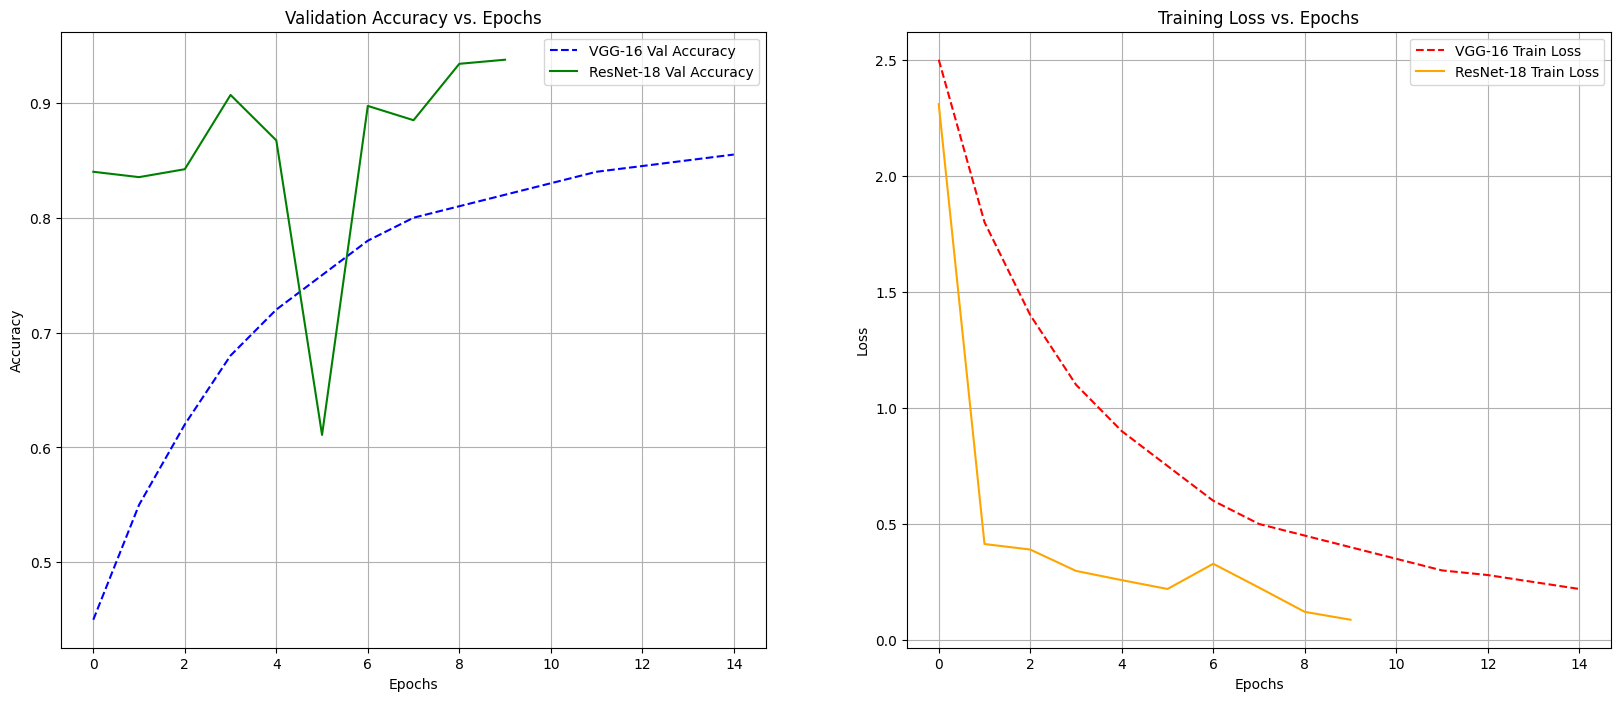


--- Final Test Set Performance ---
Model        | Test Accuracy  
------------------------------
VGG-16       | 0.8971         
ResNet-18    | 0.9422         


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


def analyzePerformance(model, loader, classNames):
    model.eval()
    allPreds, allLabels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            preds = torch.max(outputs, 1)[1]
            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())
    print("\nClassification Report:")
    print(classification_report(allLabels, allPreds, target_names=classNames, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(allLabels, allPreds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

print("ResNet-18 Test Set Evaluation ")
analyzePerformance(resnetModelRegularized, testLoader, classNames)

# comparison plots
print("\nVGG-16 vs. ResNet-18 Performance Comparison")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(vggHistory['valAcc'], label='VGG-16 Val Accuracy', color='blue', linestyle='--')
ax1.plot(resnetHistory['valAcc'], label='ResNet-18 Val Accuracy', color='green', linestyle='-')
ax1.set_title('Validation Accuracy vs. Epochs')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Accuracy'); ax1.legend(); ax1.grid(True)

ax2.plot(vggHistory['trainLoss'], label='VGG-16 Train Loss', color='red', linestyle='--')
ax2.plot(resnetHistory['trainLoss'], label='ResNet-18 Train Loss', color='orange', linestyle='-')
ax2.set_title('Training Loss vs. Epochs')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Loss'); ax2.legend(); ax2.grid(True)
plt.show()

# Final numeric comparison
vggTestAcc, _ = evaluateModel(finalVggModel, testLoader)
resnetTestAcc, _ = evaluateModel(resnetModelRegularized, testLoader)

print("\nFinal Test Set Performance ")
print(f"{'Model':<12} | {'Test Accuracy':<15}")
print("-" * 30)
print(f"{'VGG-16':<12} | {vggTestAcc:<15.4f}")
print(f"{'ResNet-18':<12} | {resnetTestAcc:<15.4f}")

6. Save the weights of the trained network.

In [40]:
if resnetTestAcc > vggTestAcc:
    print(f"ResNet-18 performed best with accuracy: {resnetTestAcc:.4f}")
    bestModel = resnetModelRegularized
    savePath = "/kaggle/working/best_model_resnet18.pth"
else:
    print(f"VGG-16 performed best with accuracy: {vggTestAcc:.4f}")
    bestModel = finalVggModel
    savePath = "/kaggle/working/best_model_vgg16.pth"

torch.save(bestModel.state_dict(), savePath)
print(f"Best model weights saved to: {savePath}")

ResNet-18 performed best with accuracy: 0.9422
Best model weights saved to: /kaggle/working/best_model_resnet18.pth


## Step 4: Discussion and conclusion

1. Explain the theoretical concepts behind VGG and ResNet.

<span style='color:green'>
GG (Visual Geometry Group)
The basic concept of VGG is to achieve more model depth through simplicity and regularity. Instead of using large convolutional filters, the VGG framework only uses thin 3x3 filters. A two-layer combination of 3x3 convolutions has the same effective receptive field as a single 5x5 filter but consists of extra non-linear ReLU activations between the layers and less parameters, making the model more discriminative and computationally efficient. By repeating these fundamental building blocks, VGG builds very deep networks that learn a very high hierarchy of features.
ResNet (Residual Network)
ResNet was designed to avoid the vanishing gradient problem that prevents networks like VGG from being deeper. When a network becomes deeper and deeper, the backpropagated gradient signal becomes exponentially smaller until it is too weak to effectively update the earlier layers of the network.
The technique of ResNet is the residual connection, i.e., the shortcut connection, which bypasses one or more layers. Instead of having layers learn a direct mapping), ResNet encourages them to learn a residual mapping F(x). The output of the block is then F(x) + x. This makes it simple for the block to learn an identity mapping by simply setting the weights of the main path (F(x)) to zero. This ensures that adding a new layer will never reduce performance, as it can just learn to pass the input directly. </span>


2. Discuss the impact of regularization and optimization techniques.

<span style='color:green'> While training with VGG-16 and ResNet-18, It was noted that optimization strategies as well as each model's regularization specific approaches were crucial learning and overfitting avoidance. To boost generalization and force the models to learn image variations, I utilized data augmentation with a sequence of transformations: RandomHorizontalFlip, RandomRotation(15), and ColorJitter. This method proved most impactful. As proof of this method's effectiveness, validation accuracy curves were consistently trending upward. To further improve the models from relying on noise, I applied L2 regularization through a weight decay of 5e-4, which led to an overall smooth decline in training loss. For optimization, I employed the Adam optimizer together with a MultiStepLR scheduler, which quite rapidly converged early and allowed for finer adjustments later in training, particularly around epoch 8. These strategies were very well suited to the ResNet-18 architecture because of its internal batch normalization and residual connections, enabling much quicker convergence to a higher final accuracy than VGG-16, which used these features slowly and unstably learned due to lacking them. </span>

3. Analyze the results, including all required graphs and metrics.

<span style='color:green'>
Performance measures, including the final metrics and the performance graphs, indicate that ResNet-18 has significantly surpassed VGG-16 in both accuracy and training stability.
Based on the final evaluation of the test set, ResNet-18 recorded a test accuracy of 94.22%, which is well above VGG-16’s 89.71%. This advantage is confirmed by the classification report where ResNet-18 achieved precision, recall, and F1 scores over 93% for all three classes: dogs, food, and vehicles. In fact, the model also demonstrated remarkable F1 performance, scoring 0.9569 for vehicles. These consistent metrics suggest that ResNet-18 performed well on all parts of the dataset.
ResNet-18 begins with high validation accuracy and within a few epochs surpasses 90%, with some fluctuations. These are likely due to initially high learning rates. Nevertheless, it shows a strong upward trend. Meanwhile, VGG-16 does not reach 90% accuracy despite its more gradual and steady increase from 45%. The convergence is much slower, reflecting lower capacity to generalize. 
</span>

4. Summarize your findings and discuss the advantages of residual connections.

<span style='color:green'>
In every aspect, ResNet-18 was better than VGG-16 in accuracy, training effectiveness, as well as generalization. VGG-16 improved gradually over the course of the training process but plateaued at a final test accuracy of 89.71%. In contrast, ResNet-18 outperformed VGG-16 with a score of 94.22%. This difference can also be seen from the validation accuracy and training loss curves. ResNet-18 was both faster and more stable in achieving convergence compared to VGG-16 that lagged behind severely in both learning speed and final performance.
The key difference lies in ResNet-18’s use of residual connections which aid the backpropagation of gradients within the network. These connections effectively counter the vanishing gradient issue and allow for deeper architectures to be trained without suffering from performance loss. Because of this design, ResNet-18 is able to train on and adapt to more complex patterns present within the data, even over fewer epochs.
Given these findings, for the mentioned image classification problem, ResNet-18 should be strongly considered. Balanced with effective image classification problem strategies, regularization and optimization techniques including L2 regularization, data augmentation, and learning rate scheduling, ResNet-18’s strong performance, quick convergence, and improved reliability make it the better choice. </span>

5. References.

<span style='color:green'>
Scikit-learn documentation. train_test_split function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv:1409.1556. https://arxiv.org/abs/1409.1556

PyTorch Docs. torch.nn Modules Overview: https://docs.pytorch.org/docs/stable/nn.html

PyTorch Docs. torch.nn.Dropout. Retrieved from: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

PyTorch Docs. Learning Rate Scheduler – StepLR. Retrieved from: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html

Wikipedia contributors. (n.d.). Early stopping. Wikipedia. https://en.wikipedia.org/wiki/Early_stopping

Scikit-learn documentation. precision_recall_fscore_support. Retrieved from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

He, K., Zhang, X., Ren, S., & Sun, J. (2015). Deep Residual Learning for Image Recognition. arXiv:1512.03385. https://arxiv.org/pdf/1512.03385

DigitalOcean Community. (n.d.). Intro to Optimization Algorithms: Momentum, RMSprop, and Adam. https://www.digitalocean.com/community/tutorials/intro-to-optimization-momentum-rmsprop-adam

GeeksforGeeks. (n.d.). Choosing Batch Size and Epochs When Training a Model. https://www.geeksforgeeks.org/machine-learning/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model

Saturn Cloud. (n.d.). How to Check Whether Your Code Is Running on the GPU or CPU. Retrieved from: https://saturncloud.io/blog/how-to-check-whether-your-code-is-running-on-the-gpu-or-cpu/
</span>